# Attention Model from scratch: tutorial

feat. Heterogeneuous Attention Model


Brief intro: implementation-wise, the biggest differences with most RL libraries are:
1. We use [TorchRL](https://github.com/pytorch/rl) for batched environments on GPU - tackling one of the biggest bottlenecks in RL (CPU-GPU overheads)
2. We pass states and more in the super-convenient [TensorDicts](https://github.com/pytorch-labs/tensordict)
3. Training is done in [PyTorch Lightning](https://github.com/Lightning-AI/lightning), which takes care of multiple devices, logging, checkpointing, etc.
4. We use [Hydra](https://hydra.cc/) for configuration management
5. Code is made to be as modular as possible and implemented with the latest DL advances as [FlashAttention](https://github.com/HazyResearch/flash-attention)


This should allow for easy, fast, and scalable experimentation in the future and we hope to become the to-go library for RL4CO research 🚀

In [1]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append('../../')

from omegaconf import OmegaConf, DictConfig

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import lightning as L
from tensordict import TensorDict

from rl4co.envs import PDPEnv
from rl4co.models.rl.reinforce.baselines import RolloutBaseline, WarmupBaseline, ExponentialBaseline
from rl4co.data.dataset import TensorDictCollate, TensorDictDataset

/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/torchrl/__init__.py:26: UserWarning: failed to set start method to spawn, and current start method for mp is fork.
  warn(
/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Environment
We test on a simple TSP environment

In [2]:
def random_policy(td):
    """Helper function to select a random action from available actions"""
    action = torch.multinomial(td["action_mask"].float(), 1).squeeze(-1)
    td.set("action", action)
    return td


def rollout(env, td, policy):
    """Helper function to rollout a policy"""
    actions = []
    while not td["done"].all():
        td = policy(td)
        actions.append(td["action"])
        td = env.step(td)["next"]
    actions = torch.stack(actions, dim=1)
    td.set("action", actions)
    return td

In [3]:
env = PDPEnv(num_loc=20)

td = env.reset(batch_size=[5])
init_td = td.clone()
td = rollout(env, td, random_policy)
env.get_reward(td, td['action'])

tensor([-10.8122, -11.6597,  -8.5621, -10.1766,  -9.3012])

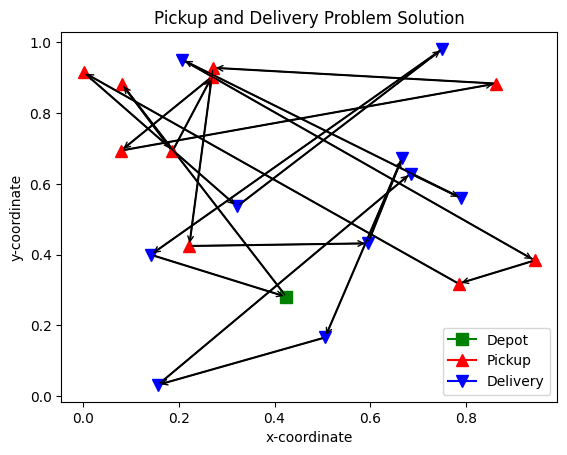

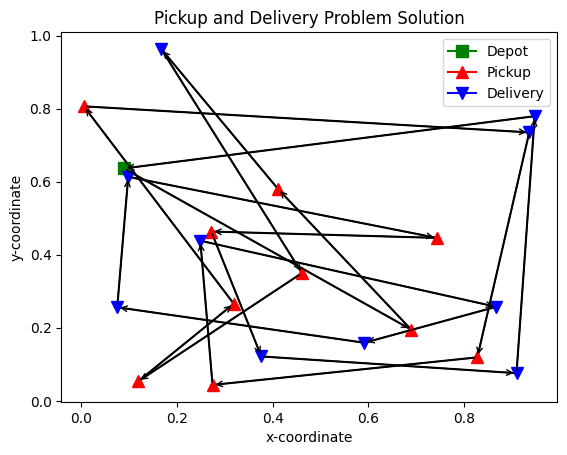

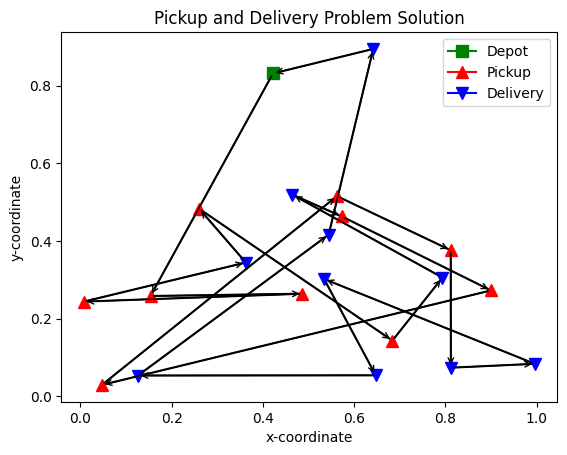

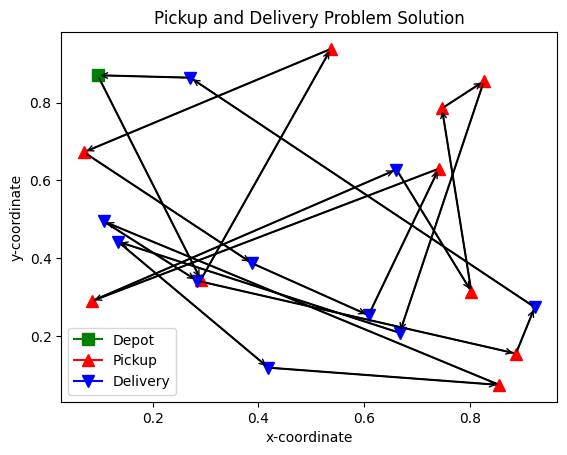

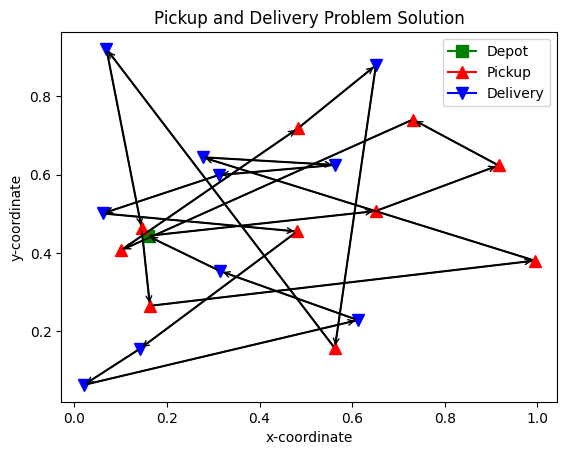

In [4]:
# Plot 
render_td = td.clone()
render_td.set('to_deliver', init_td['to_deliver'])

for i in range(5):
    env.render(render_td[i])

## Encoder

We use a `GraphHeterogeneousAttentionEncoder` that is shared with most models (we just import it from RL4CO)

In [5]:
from rl4co.models.zoo.ham.encoder import GraphHeterogeneousAttentionEncoder
# ?? GraphHeterogeneousAttentionEncoder

## Decoder 

We can also simply import it from AM

In [6]:
from rl4co.models.zoo.am.decoder import Decoder
# ?? Decoder

## Policy

The policy takes an initial state and gives back collected rewards and log likelihood. We can also return extras such as actions

In [7]:
from rl4co.models.zoo.am.policy import AttentionModelPolicy
# ?? AttentionModelPolicy

In [8]:
# Load environment with test data
env = PDPEnv(num_loc=20)

# Encoder params
embedding_dim = 128
num_layers = 3
num_heads = 8

dataset = env.dataset(batch_size=[10000])

dataloader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=False,  # no need to shuffle, we're resampling every epoch
    num_workers=0,
    collate_fn=TensorDictCollate(),
)

# NOTE: declaring encoder / decoder will override the default ones in the policy
policy = AttentionModelPolicy(
    env,
    encoder=GraphHeterogeneousAttentionEncoder( # override the encoder with our own
        num_heads=num_heads,
        embed_dim=embedding_dim,
        num_layers=num_layers,
    ),
    decoder=Decoder(env, embedding_dim=embedding_dim, num_heads=num_heads),
    num_heads=num_heads,
    embedding_dim=embedding_dim,

).to("cuda")

td = next(iter(dataloader)).to("cuda")
td = env.reset(td)

out = policy(td, decode_type="sampling", return_actions=False)

print(out)

{'reward': tensor([-11.2107, -10.8156, -10.6247, -13.0508, -13.0566, -11.2248, -11.2615,
        -11.2177, -12.0038, -10.3224, -10.4532, -12.2282, -11.0899, -13.4502,
         -9.7080,  -8.1072,  -9.0968, -11.7972,  -8.7020, -11.0255, -10.2270,
        -10.5130, -12.1249, -11.7520, -11.4203, -13.8855, -10.3322, -10.3568,
        -11.5596, -11.2873,  -9.2388, -11.1926, -11.4077, -10.5355, -10.2904,
        -11.0203, -11.9067, -10.6025,  -9.0597,  -9.6939, -11.0883, -10.5071,
         -8.9295,  -9.6274, -10.5177, -11.0641, -11.6984, -11.7208,  -8.0059,
        -11.1451, -10.0569, -12.1848, -10.9655,  -9.9902, -11.8960, -10.0200,
        -10.6034,  -8.6520, -10.9460, -12.8029, -10.7397,  -9.4410, -10.9165,
        -10.5961], device='cuda:0'), 'log_likelihood': tensor([-26.1109, -20.5162, -36.0616, -26.4746, -29.5004, -31.7360, -26.4823,
        -21.0405, -27.6349, -32.4734, -27.2329, -30.8881, -28.7711, -23.7676,
        -25.6726, -26.5035, -27.3155, -25.6871, -33.8419, -35.4335, -21.3217

## Create full AM: `env` + `policy` + `baseline`

The full model includes REINFORCE baseline and the policy: it contains the logic for training. 
For example, in REINFORCE with a rollout baseline, a copy of the policy is used as the baseline to calculate the advantages and it is updated only when the new policy is actually better than the baseline.

In [9]:
from rl4co.models.zoo.am.model import AttentionModel

In [10]:
baseline = WarmupBaseline(RolloutBaseline())

model = AttentionModel(
    env,
    policy,
    baseline=baseline,
).to("cuda")


td = next(iter(dataloader)).to("cuda")
td = env.reset(td)

out = model(td, decode_type="sampling")

print(out)

{'reward': tensor([-10.5430,  -9.7581, -10.2352, -11.6150, -11.6629, -11.1075, -11.9987,
        -12.5494, -11.2849, -12.2120, -11.1615, -11.7047, -11.1800, -11.2409,
        -10.8907,  -8.8346,  -9.8435, -11.5891,  -9.9754, -10.4497,  -9.8871,
        -11.0448, -12.6524, -11.5008, -10.5440, -12.7071,  -9.6426, -10.1045,
         -9.2409, -12.9087,  -8.6495,  -9.7292, -10.2444,  -9.3382, -10.6353,
        -10.3325, -10.1764, -12.1371,  -8.2196, -11.7925, -10.0781,  -9.3160,
         -8.7409, -10.1802,  -8.4809, -11.3149, -10.9660,  -9.9608,  -8.1078,
         -9.6186,  -8.8938, -12.5552, -11.9559,  -9.1250, -12.8308, -13.0744,
        -10.0089,  -7.8470, -10.6843, -11.4950, -10.7311,  -9.7696, -10.7413,
        -11.0932], device='cuda:0'), 'log_likelihood': tensor([-27.1406, -17.3589, -30.1416, -25.0839, -21.5331, -19.2174, -33.4556,
        -15.1837, -26.7594, -26.5138, -30.4956, -29.6030, -34.6726, -30.6718,
        -33.6564, -29.5994, -31.8205, -25.9771, -35.5485, -32.0140, -28.1587

## Lightning Module

Same as before, let's simply import it from RL4CO: no need to reinvet the wheel!

In [11]:
from rl4co.tasks.rl4co import RL4COLitModule
# ?? RL4COLitModule

## Main training setup

In [15]:

config = DictConfig(
    {
        "data": {
            "train_size": 100000, # with 1 epochs, this is 1k samples
            "val_size": 10000, 
            "train_batch_size": 512,
            "val_batch_size": 1024,
        },
        "optimizer": {
            "_target_": "torch.optim.Adam",
            "lr": 1e-4,
            "weight_decay": 1e-5,
        },
        "metrics": {
            "train": ["loss", "reward"],
            "val": ["reward"],
            "test": ["reward"],
            "log_on_step": True,
        },
        
    }
)

lit_module = RL4COLitModule(config, env, model)

# lit_module = RL4COLitModule(env, model, config)

## Fit model

In [16]:
# Set debugging level as info to see all message printouts
import logging
logging.basicConfig(level=logging.INFO)

# Trick to make calculations faster
torch.set_float32_matmul_precision("medium")

# Trainer
trainer = L.Trainer(
    max_epochs=10, # 10
    accelerator="gpu",
    logger=None, # can replace with WandbLogger, TensorBoardLogger, etc.
    precision="16-mixed", # Lightning will handle casting to float16
    log_every_n_steps=1,   
    gradient_clip_val=1.0, # clip gradients to avoid exploding gradients!
    reload_dataloaders_every_n_epochs=1, # necessary for sampling new data
)

# Fit the model
trainer.fit(lit_module)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:rl4co.tasks.rl4co:Setting up datasets
INFO:rl4co.models.rl.reinforce.baselines:Creating evaluation dataset for rollout baseline
INFO:rl4co.models.rl.reinforce.baselines:Evaluating baseline model on evaluation dataset
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:rl4co.tasks.rl4co:No optimizer specified, using default
INFO:rl4co.tasks.rl4co:Instantiating optimizer <torch.optim.Adam>

  | Name  | Type           | Params
-----------------------------------------
0 | env   | PDPEnv         | 0     
1 | model | AttentionModel | 2.0 M 
-----------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.903     Total estimated model params size (MB)


/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 196/196 [00:09<00:00, 19.89it/s, v_num=12, train/reward=-6.08, train/loss=-.201, val/reward=-5.92]

INFO:rl4co.models.rl.reinforce.baselines:Evaluating candidate model on evaluation dataset
INFO:rl4co.models.rl.reinforce.baselines:Candidate mean: -5.916, Baseline mean: -7.523
INFO:rl4co.models.rl.reinforce.baselines:p-value: 0.000
INFO:rl4co.models.rl.reinforce.baselines:Updating baseline
INFO:rl4co.models.rl.reinforce.baselines:Creating evaluation dataset for rollout baseline
INFO:rl4co.models.rl.reinforce.baselines:Evaluating baseline model on evaluation dataset
INFO:rl4co.models.rl.reinforce.baselines:Set warmup alpha = 1.0


Epoch 1: 100%|██████████| 196/196 [00:09<00:00, 20.74it/s, v_num=12, train/reward=-5.79, train/loss=0.00639, val/reward=-5.70]

INFO:rl4co.models.rl.reinforce.baselines:Evaluating candidate model on evaluation dataset
INFO:rl4co.models.rl.reinforce.baselines:Candidate mean: -5.673, Baseline mean: -5.896
INFO:rl4co.models.rl.reinforce.baselines:p-value: 0.000
INFO:rl4co.models.rl.reinforce.baselines:Updating baseline
INFO:rl4co.models.rl.reinforce.baselines:Creating evaluation dataset for rollout baseline
INFO:rl4co.models.rl.reinforce.baselines:Evaluating baseline model on evaluation dataset


Epoch 2: 100%|██████████| 196/196 [00:09<00:00, 20.74it/s, v_num=12, train/reward=-5.68, train/loss=-.890, val/reward=-5.64]  

INFO:rl4co.models.rl.reinforce.baselines:Evaluating candidate model on evaluation dataset
INFO:rl4co.models.rl.reinforce.baselines:Candidate mean: -5.623, Baseline mean: -5.681
INFO:rl4co.models.rl.reinforce.baselines:p-value: 0.000
INFO:rl4co.models.rl.reinforce.baselines:Updating baseline
INFO:rl4co.models.rl.reinforce.baselines:Creating evaluation dataset for rollout baseline
INFO:rl4co.models.rl.reinforce.baselines:Evaluating baseline model on evaluation dataset


Epoch 3: 100%|██████████| 196/196 [00:09<00:00, 19.75it/s, v_num=12, train/reward=-5.62, train/loss=-.528, val/reward=-5.54] 

INFO:rl4co.models.rl.reinforce.baselines:Evaluating candidate model on evaluation dataset
INFO:rl4co.models.rl.reinforce.baselines:Candidate mean: -5.524, Baseline mean: -5.624
INFO:rl4co.models.rl.reinforce.baselines:p-value: 0.000
INFO:rl4co.models.rl.reinforce.baselines:Updating baseline
INFO:rl4co.models.rl.reinforce.baselines:Creating evaluation dataset for rollout baseline
INFO:rl4co.models.rl.reinforce.baselines:Evaluating baseline model on evaluation dataset


Epoch 4: 100%|██████████| 196/196 [00:09<00:00, 20.16it/s, v_num=12, train/reward=-5.58, train/loss=-.633, val/reward=-5.50] 

INFO:rl4co.models.rl.reinforce.baselines:Evaluating candidate model on evaluation dataset
INFO:rl4co.models.rl.reinforce.baselines:Candidate mean: -5.496, Baseline mean: -5.517
INFO:rl4co.models.rl.reinforce.baselines:p-value: 0.000
INFO:rl4co.models.rl.reinforce.baselines:Updating baseline
INFO:rl4co.models.rl.reinforce.baselines:Creating evaluation dataset for rollout baseline
INFO:rl4co.models.rl.reinforce.baselines:Evaluating baseline model on evaluation dataset


Epoch 5: 100%|██████████| 196/196 [00:09<00:00, 20.87it/s, v_num=12, train/reward=-5.44, train/loss=-.279, val/reward=-5.42]  

INFO:rl4co.models.rl.reinforce.baselines:Evaluating candidate model on evaluation dataset
INFO:rl4co.models.rl.reinforce.baselines:Candidate mean: -5.417, Baseline mean: -5.507
INFO:rl4co.models.rl.reinforce.baselines:p-value: 0.000
INFO:rl4co.models.rl.reinforce.baselines:Updating baseline
INFO:rl4co.models.rl.reinforce.baselines:Creating evaluation dataset for rollout baseline
INFO:rl4co.models.rl.reinforce.baselines:Evaluating baseline model on evaluation dataset


Epoch 6: 100%|██████████| 196/196 [00:09<00:00, 20.78it/s, v_num=12, train/reward=-5.48, train/loss=-.314, val/reward=-5.39]

INFO:rl4co.models.rl.reinforce.baselines:Evaluating candidate model on evaluation dataset
INFO:rl4co.models.rl.reinforce.baselines:Candidate mean: -5.359, Baseline mean: -5.399
INFO:rl4co.models.rl.reinforce.baselines:p-value: 0.000
INFO:rl4co.models.rl.reinforce.baselines:Updating baseline
INFO:rl4co.models.rl.reinforce.baselines:Creating evaluation dataset for rollout baseline
INFO:rl4co.models.rl.reinforce.baselines:Evaluating baseline model on evaluation dataset


Epoch 7: 100%|██████████| 196/196 [00:09<00:00, 20.25it/s, v_num=12, train/reward=-5.38, train/loss=-.450, val/reward=-5.31]

INFO:rl4co.models.rl.reinforce.baselines:Evaluating candidate model on evaluation dataset
INFO:rl4co.models.rl.reinforce.baselines:Candidate mean: -5.307, Baseline mean: -5.378
INFO:rl4co.models.rl.reinforce.baselines:p-value: 0.000
INFO:rl4co.models.rl.reinforce.baselines:Updating baseline
INFO:rl4co.models.rl.reinforce.baselines:Creating evaluation dataset for rollout baseline
INFO:rl4co.models.rl.reinforce.baselines:Evaluating baseline model on evaluation dataset


Epoch 8: 100%|██████████| 196/196 [00:09<00:00, 20.81it/s, v_num=12, train/reward=-5.37, train/loss=-.603, val/reward=-5.29]

INFO:rl4co.models.rl.reinforce.baselines:Evaluating candidate model on evaluation dataset
INFO:rl4co.models.rl.reinforce.baselines:Candidate mean: -5.273, Baseline mean: -5.286
INFO:rl4co.models.rl.reinforce.baselines:p-value: 0.000
INFO:rl4co.models.rl.reinforce.baselines:Updating baseline
INFO:rl4co.models.rl.reinforce.baselines:Creating evaluation dataset for rollout baseline
INFO:rl4co.models.rl.reinforce.baselines:Evaluating baseline model on evaluation dataset


Epoch 9: 100%|██████████| 196/196 [00:09<00:00, 20.20it/s, v_num=12, train/reward=-5.31, train/loss=-.336, val/reward=-5.28]

INFO:rl4co.models.rl.reinforce.baselines:Evaluating candidate model on evaluation dataset
INFO:rl4co.models.rl.reinforce.baselines:Candidate mean: -5.260, Baseline mean: -5.283
INFO:rl4co.models.rl.reinforce.baselines:p-value: 0.000
INFO:rl4co.models.rl.reinforce.baselines:Updating baseline
INFO:rl4co.models.rl.reinforce.baselines:Creating evaluation dataset for rollout baseline
INFO:rl4co.models.rl.reinforce.baselines:Evaluating baseline model on evaluation dataset
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 196/196 [00:13<00:00, 14.53it/s, v_num=12, train/reward=-5.31, train/loss=-.336, val/reward=-5.28]


In [17]:
trainer.test(lit_module)

INFO:rl4co.tasks.rl4co:Setting up datasets
INFO:rl4co.models.rl.reinforce.baselines:Creating evaluation dataset for rollout baseline
INFO:rl4co.models.rl.reinforce.baselines:Evaluating baseline model on evaluation dataset
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 55.45it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test/reward        │    -5.270094871520996     │
└───────────────────────────┴───────────────────────────┘

[{'test/reward': -5.270094871520996}]

## Analyze results

In [20]:
lit_module.cfg.data.batch_size = 100 # so we load the whole test set
dl = lit_module.test_dataloader()
policy = lit_module.model.policy.to("cuda")

batch = next(iter(dl))
td = env.reset(batch).to("cuda")
out = policy(td, decode_type="greedy", return_actions=True)
out['reward'].mean()

tensor(-5.8036, device='cuda:0')

Reward: -4.976064682006836


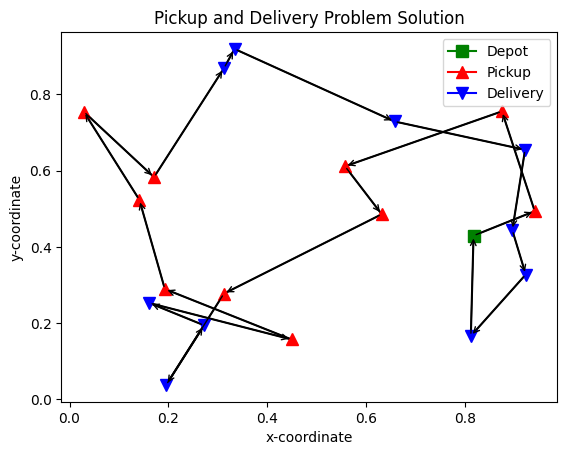

Reward: -6.206596374511719


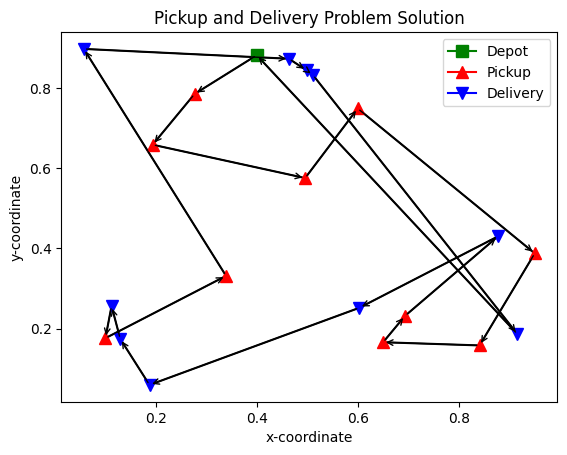

Reward: -6.176373481750488


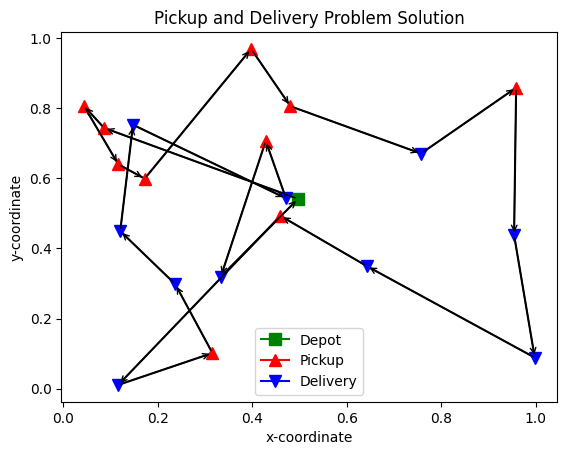

Reward: -4.865335464477539


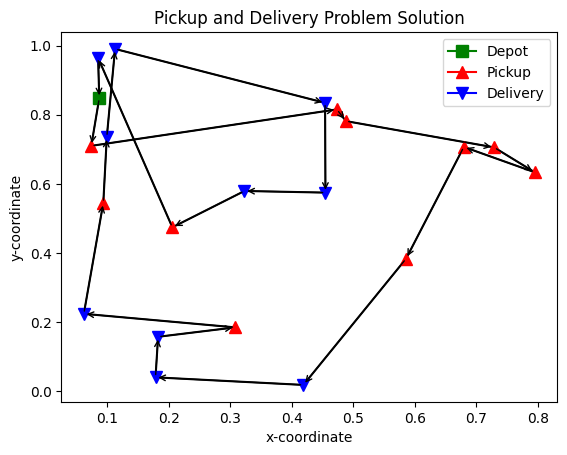

Reward: -5.80899715423584


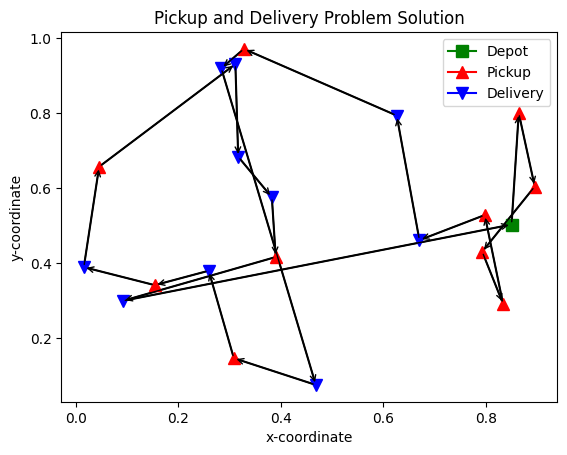

In [21]:
td.set('reward', out['reward'])
td.set('action', out['actions'])
for i in range(5):
    print("Reward:", td['reward'][i].item())
    env.render(td[i])